# Camera Calibration

Today, we will do camera calibration using OpenCV and ArUco boards.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'

In [2]:
import glob

In [12]:
# loading the images to use for calibration
image_names = glob.glob('images/*.jpeg')

We have loaded the images of the ArUco board that were taken from different angles. We now load the dictionary that was used for those boards and the board object used to create them.

In [4]:
#load the dictionary
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

# Create board object (same that was printed)
gridboard = cv2.aruco.GridBoard((6, 8), 0.0762, 0.0067, dictionary)

Next, we create the ArUco board detector object. It's work is to detect the ArUco boards given an image. The constructor takes 3 arguments: a dictionary, `DetectorParameters` and `refineParameters` objects. All the parameters come with defaults. However, in our case, the default dictionary is not the one that we used hence we will specify the dictionary and use the defauults for the other parameters. There is also a standalone method `aruco.detectMarkers` that does this.

In [7]:
#ArUco board detector
detector = cv2.aruco.ArucoDetector(dictionary)

In [40]:
all_ids = []
all_corners = []
all_rejected = []
all_recovered = []

#detect corners and Ids
if image_names is not None:
    for image_path in image_names:
        image = cv2.imread(image_path)
        corners, ids, rejected  = detector.detectMarkers(image)
    
        #refine markers
        corners, ids, rejected, recovered = detector.refineDetectedMarkers(image, gridboard, corners, ids, rejected)
        all_corners.append(corners)
        all_ids.append(ids)
        all_rejected.append(rejected)
        all_recovered.append(recovered)

We now have all the ids and the corners of the boards. Since we have refined our recoveries, we first see if we have recovered anything.

In [41]:
all_recovered

[None, None, None, None, None, None, None, None]

Next let us draw one image and see what comes out

(-0.5, 959.5, 1279.5, -0.5)

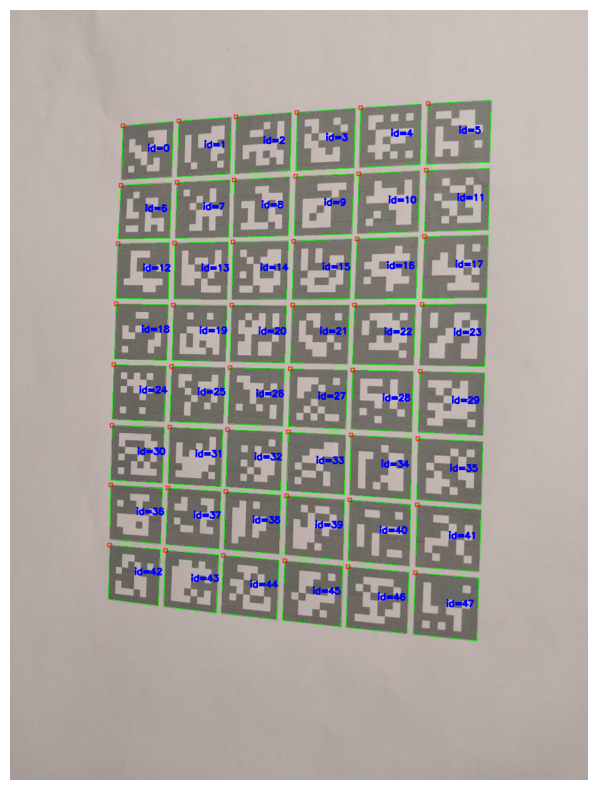

In [86]:
pos = 5
#read the image only when needed
draw_markers = cv2.imread(image_names[pos])
cv2.aruco.drawDetectedMarkers(draw_markers, all_corners[pos], all_ids[pos])

plt.figure(figsize=[10, 10])
plt.imshow(draw_markers[:, :, ::-1]); plt.axis('off')

We can see that our corners have been detected properly. The next thing we do is to prepare data for calibration. For this we need to match the image points and object points of the image. We iterate through all the image points and object points (points in the board) and match the up. We do this using the `matchImagePoints` method in the board object.

In [51]:
objPoints = []
imgPoints = []
for image in range(len(image_names)):
    currentobjpoints, currentimgpoints = gridboard.matchImagePoints(all_corners[image], all_ids[image])
    objPoints.append(currentobjpoints)
    imgPoints.append(currentimgpoints)

Now that we have our object points and image points, we can now calibrate our camera.

In [56]:
repError, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, draw_markers.shape[:2][::-1], None, None)

Now we have the camera intrinsics and extrinsics. We can now use the rotation and translation vectors for pose estimation.

## Board Pose Estimation

We can draw the pose of the board using `drawFrameAxes`.

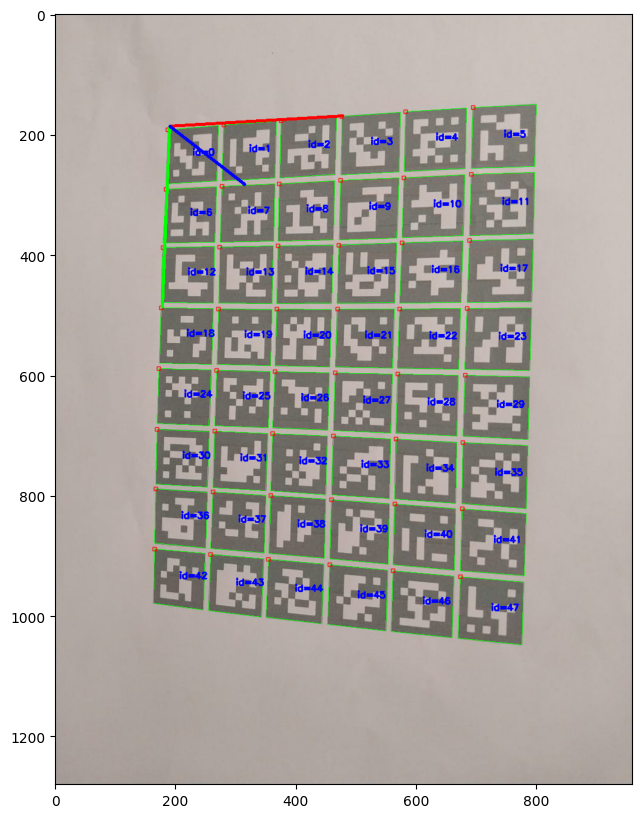

In [89]:
axis_frame = draw_markers.copy()
markerLength = gridboard.getMarkerLength()
markerSeparation = gridboard.getMarkerSeparation()
markersX = draw_markers.shape[1]
markersY = draw_markers.shape[0]
axisLength = 3 * (markerLength + markerSeparation)

_ = cv2.drawFrameAxes(axis_frame, cameraMatrix, distCoeffs, rvecs[pos], tvecs[pos], axisLength)

plt.figure(figsize=[10, 10])
plt.imshow(axis_frame[:, :, ::-1])

# Calibrating using ChArUco boards

Calibration using ChArUco boards is the same with the slightvarioation of using a `CharucoDetector` and a `CharucoBoard` unlike the `ArucoDetector` and `ArucoBoard` we have used in the example above.

Useful OpenCV links:
<br>
[camera calibration checkboard](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).
<br>
[camera calibration aruco and charuco](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html).
<br>
[diamond pose estimation](https://docs.opencv.org/4.x/d5/d07/tutorial_charuco_diamond_detection.html).
<br>
[detection of aruco boards](https://docs.opencv.org/4.x/db/da9/tutorial_aruco_board_detection.html).